In [243]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2024)

tc = create_taiga_client_v3()


In [366]:

class OrderParamClassifier:
    """to classify samples based on their gene expression profiles and their corresponding cell or disease type annotations. """
    def __init__(self, expr, markers, num_samples): 
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples= num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)

def get_gene_map(tc):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type','entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()),'depmap'] = np.nan
    #ensembl = generateGeneNames(attributes=['ensembl_transcript_id'])
    #hgnc['ensembl_transcript_id'] = pd.merge(hgnc.ensembl_gene_id,ensembl.set_index('ensembl_gene_id').ensembl_transcript_id)
    return hgnc

def get_tcga_classifier(num_samples):
    """
    """
    # Get and fill missing values with 0 in TCGA expression data
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    
    # Get DepMap expression data
    depmap = tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
    
    # Retrieve gene map
    gene_map = get_gene_map(tc)
    
    # Rename DepMap expression data columns based on gene map ensembl_gene_id column 
    expr_depmap = depmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())
    
    # Identify common genes between TCGA and DepMap expression data
    commongenes = tcga_expr.columns.intersection(expr_depmap.columns)
    
    # Subset TCGA expression data to keep only the common genes
    tcga_expr = tcga_expr[commongenes]
    
    # Read TCGA metadata 
    tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv')
    # Update derived_subtype and new_subtype columns
    # Update derived_subtype and new_subtype columns
    tcga_meta.loc[tcga_meta['subtype'] == 'colon adenocarcinoma', ['derived_subtype', 'new_subtype']] = 'colon adenocarcinoma'
    # Update derived_lineage to 'adeno' where new_subtype is 'adeno'
    tcga_meta.loc[tcga_meta['new_subtype'] == 'adeno', 'derived_lineage'] = 'adeno'
    # Update derived_lineage to 'squamous' where new_subtype is 'squamous'
    tcga_meta.loc[tcga_meta['new_subtype'] == 'squamous', 'derived_lineage'] = 'squamous'

    
    # Set sampleID as index and get the new_subtype column for annotations
    tcga_ann = tcga_meta.set_index('sampleID').new_subtype
    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier


def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [367]:
import pandas as pd
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv')
# Update derived_subtype and new_subtype columns
tcga_meta.loc[tcga_meta['subtype'] == 'colon adenocarcinoma', ['derived_subtype', 'new_subtype']] = 'colon adenocarcinoma'
# Update derived_lineage to 'adeno' where new_subtype is 'adeno'
tcga_meta.loc[tcga_meta['new_subtype'] == 'adeno', 'derived_lineage'] = 'adeno'
# Update derived_lineage to 'squamous' where new_subtype is 'squamous'
tcga_meta.loc[tcga_meta['new_subtype'] == 'squamous', 'derived_lineage'] = 'squamous'


In [370]:
debmap=tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
metadata = tc.get('internal-24q2-3719.82/Model')
gene_map=get_gene_map(tc)
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())	# get the ensembl_gene_id column from gene_map 
#and replace the columns depmap to the values in this column 
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna()) 

In [ ]:
# the number of train samples for each subtype 
num_samples = 25
# Get the TCGA classifier with the specified number of samples
classifier = get_tcga_classifier(num_samples)
# Train the classifier
classifier.train()

In [372]:
# Identify the common genes between the columns of expr_depmap and the columns of classifier.exp
# Score the expression data from expr_depmap for the common genes using the classifier
# Drop columns with any missing values (NaN) before scoring
# Extract the projections
common_genes = expr_depmap.columns.intersection(classifier.expr.columns) 
score_data=classifier.score(expr_depmap[common_genes].dropna(axis=1))
score_data=score_data[0] # a Dataframe with columns as the samples and the rows as the subtypes 

In [373]:
Top_score=score_data.apply(lambda x: x.sort_values(ascending=False).iloc[:3].index,axis = 0)
Top_score=Top_score.T
Top_score.reset_index(inplace=True)
Top_score.rename(columns={'index': 'sample'}, inplace=True)

In [374]:
projections=score_data

In [376]:
oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()

In [377]:
#update oncotree 
#Group by 'name' and count unique 'oncotree_code' values
oncotree_code_counts = oncotree.groupby('name')['code'].nunique()
# Filter names with more than one unque OncoTree code
names_with_multiple_codes = oncotree_code_counts[oncotree_code_counts > 1]

# Fnd names with mre than one unique OncoTree code
multiple_codes = oncotree.groupby('name')['code'].nunique()
names_with_multiple_codes = multiple_codes[multiple_codes > 1].index

# Step 2: Update the 'name' column in the oncotree DataFrame
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']

oncotree['name'] = oncotree.apply(update_name, axis=1)


In [378]:
oncotree.to_csv('/Users/nabdirah/Project1/updated_oncotree.csv')

In [379]:
oncotree[oncotree['name'].str.contains('Embryonal Carcinoma')]

,code,color,name,mainType,externalReferences,tissue,children,parent,history,level,revocations,precursors
44,OEC,LightBlue,Embryonal Carcinoma (Ovary/Fallopian Tube),Germ Cell Tumor,"{'UMLS': ['C0346183'], 'NCI': ['C8108']}",Ovary/Fallopian Tube,{},OGCT,[],3,[],[]
141,EMBCA,Red,Embryonal Carcinoma (Testis),Germ Cell Tumor,"{'UMLS': ['C0238448'], 'NCI': ['C6341']}",Testis,{},NSGCT,[],3,[],[]
726,VOEC,Purple,Embryonal Carcinoma (Vulva/Vagina),Germ Cell Tumor,{},Vulva/Vagina,{},VGCT,[],3,[],[]
762,BEC,Gray,Embryonal Carcinoma (CNS/Brain),Germ Cell Tumor,"{'UMLS': ['C1333377'], 'NCI': ['C7010']}",CNS/Brain,{},BGCT,[],3,[],[]


In [ ]:
# Initialize a list to store tuples of (sample, subtype, lineage)
oncotree=oncotree.set_index('code')
subtype_names = []

# Loop through unique samples in Top_score DataFrame
for sample in Top_score['sample'].unique():
    # Get the OncotreeCode for the current sample
    code = metadata[metadata['ModelID'] == sample]['OncotreeCode'].dropna()
    
    if not code.empty:
        # Retrieve the subtype name from oncotree based on the code
        subtype = oncotree.loc[code.iloc[0]]['name']
        
        # Retrieve the corresponding lineage (tissue) for the subtype
        lineage = oncotree[oncotree['name'] == subtype]['tissue'].iloc[0]
        
        # Append the sample, subtype, and lineage to the list
        subtype_names.append((sample, subtype, lineage))

# Create a DataFrame from the subtype_names list
sample_subtype_df = pd.DataFrame(subtype_names, columns=['Sample', 'Subtype', 'Lineage'])

# DataFrame: has columns sample, subtype, lineage 
sample_subtype_df


In [ ]:
def rename_subtypes(df, column_name):
    """
    Renames subtypes that have adeno or squamous.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing samples and their subtyoes .
    - column_name (str): The name of the column where subtypes are to be renamed.
    
    Returns:
    - pd.DataFrame: The updated DataFrame with renamed subtypes.
    """
    def rename(subtype):
        if isinstance(subtype, str):
            if "adeno" in subtype.lower() and subtype.lower() not in ['lung adenocarcinoma', 'colon adenocarcinoma', 'prostate adenocarcinoma']:
                return "adeno"
            elif "squamous" in subtype.lower():
                return "squamous"
        return subtype

    df[column_name] = df[column_name].apply(rename)
    return df

renamed_subtype= rename_subtypes(sample_subtype_df, 'Subtype')
renamed_subtype

In [385]:
renamed_subtype.rename(columns={'Subtype':'subtype', 'Sample':'sample'}, inplace=True)

In [390]:
def map_cns_brain_subtypes(row):
    """
    Maps subtypes with a lineage of CNS/BRAIN to 'CNS/BRAIN', except for subtypes that contain 'Medulloblastoma'.
    Other subtypes are mapped to their original subtype value.

    Parameters:
    - row (pd.Series): A row from the DataFrame containing 'subtype' and 'lineage'.

    Returns:
    - str: Tte mapped subtype value.
    """
    if row['Lineage'] == 'CNS/Brain' and 'Medulloblastoma' not in row['subtype']:
        return 'CNS/Brain'
    else:
        return row['subtype']
renamed_subtype['new_subtype'] =renamed_subtype.apply(map_cns_brain_subtypes, axis=1)

In [504]:
renamed_subtype[renamed_subtype['new_subtype']=='Medulloblastoma']['sample'].count()

11

In [403]:
def update_subtype(row):
    if row['new_subtype'] == 'adeno':
        return 'adeno'
    elif row['new_subtype'] == 'squamous':
        return 'squamous'
    else:
        return row['Lineage']
renamed_subtype['Lineage'] = renamed_subtype.apply(update_subtype, axis=1)

In [449]:
#
renamed_subtype[['sample', 'new_subtype']].to_csv('/Users/nabdirah/Project1/debmap_samplesubtype.csv')

In [ ]:
#get sampleIDs for a given subtype 
print(', '.join(renamed_subtype[renamed_subtype.new_subtype=='adeno']['sample']))

In [339]:
renamed_subtype.rename(columns={'Subtype':'subtype', 'Sample':'sample'}, inplace=True)

In [ ]:
# contains sample IDS and top3 predicted subtypes for each sample and the subtype of this sample 
merged_df=pd.merge(Top_score,renamed_subtype, on ='sample')
merged_df.rename(columns={0:'top1', 1:'top2', 2:'top3'}, inplace=True)
merged_df

In [414]:
#Compute value counts for tcga and depmap subtypes 
tcga_counts = tcga_meta['new_subtype'].value_counts()
depmap_counts = merged_df['new_subtype'].value_counts()

# Merge the value counts and label the columns
merged_counts = pd.merge(tcga_counts, depmap_counts, left_index=True, right_index=True, how='outer', suffixes=('_tcga', '_depmap'))
merged_counts.to_csv('/Users/nabdirah/Project1/ssubtype_count.csv')

In [ ]:
morethan25=merged_counts[(merged_counts.new_subtype_tcga>25)&(merged_counts.new_subtype_depmap>10)]
uniqe_subtypes=morethan25.index.unique()
unique_df=merged_df[merged_df.new_subtype.isin(uniqe_subtypes)]

In [422]:
projections=projections.T

In [497]:
#subtypes with suffiecint samples 
unique_df.to_csv('/Users/nabdirah/Project1/7bigsubtype.csv')

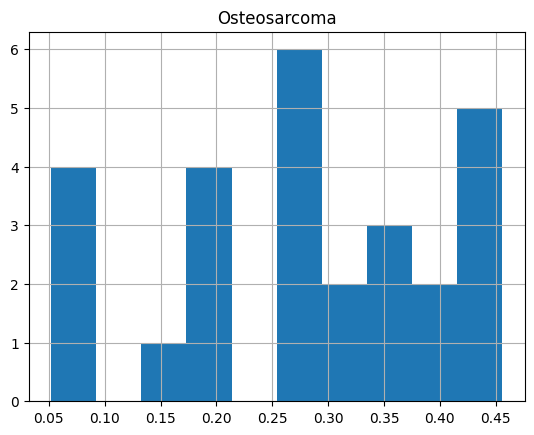

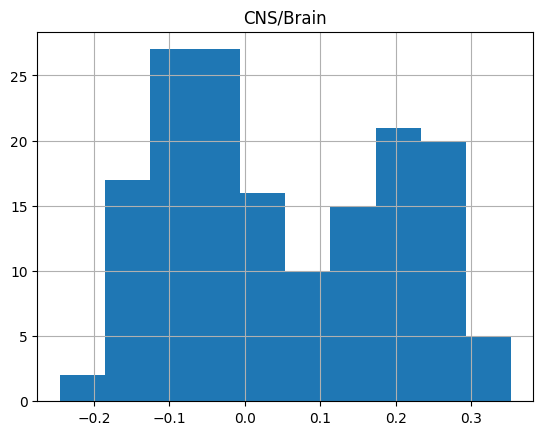

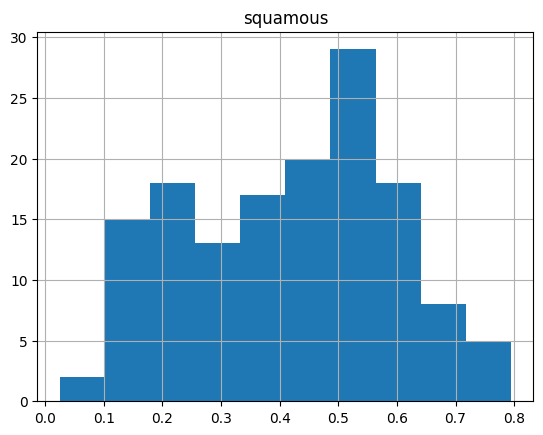

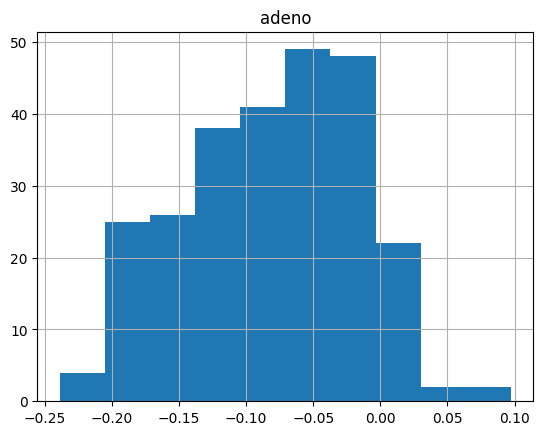

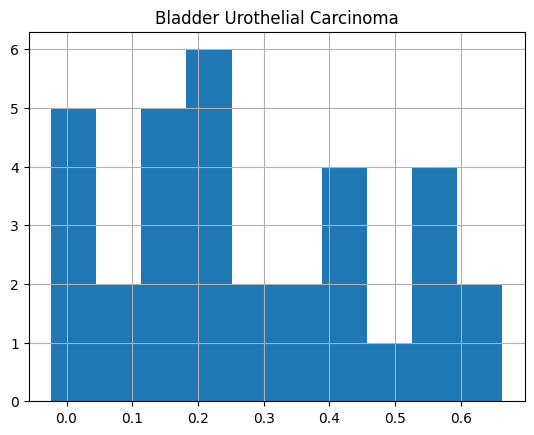

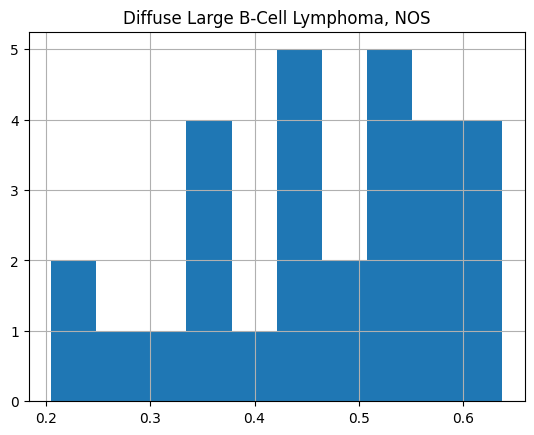

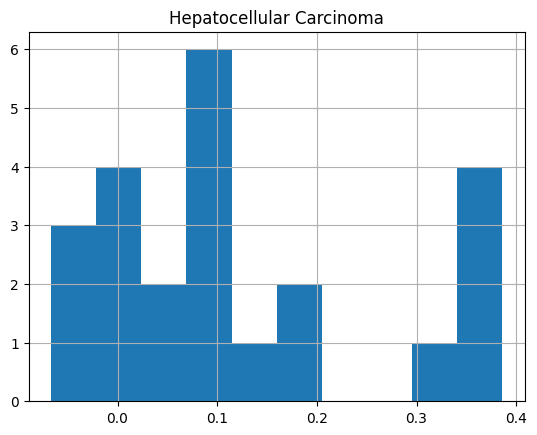

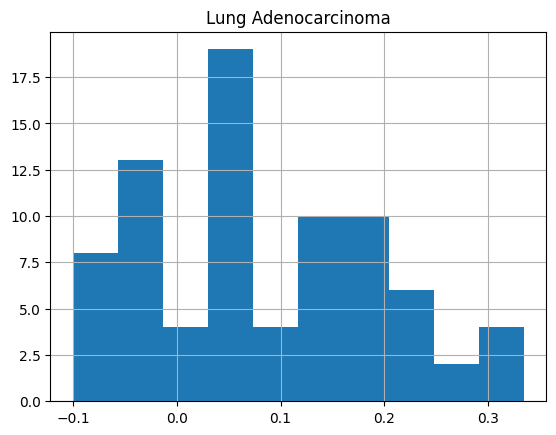

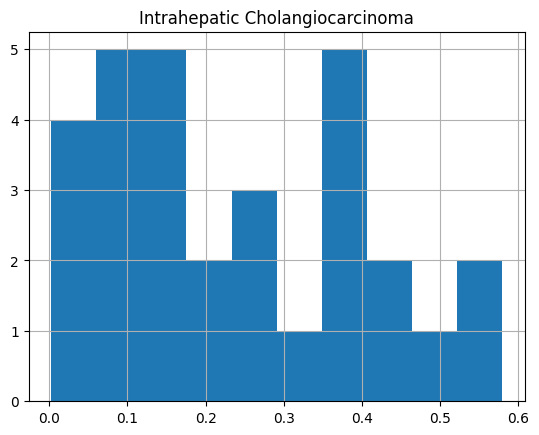

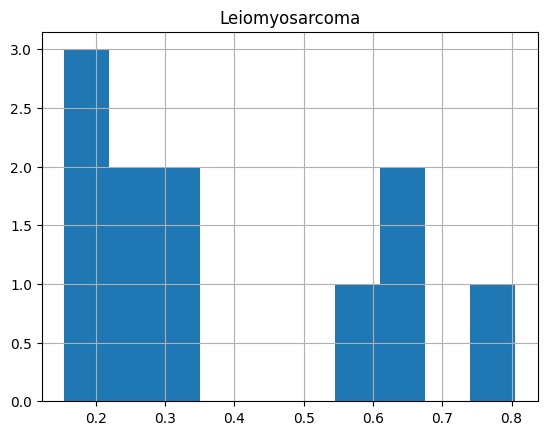

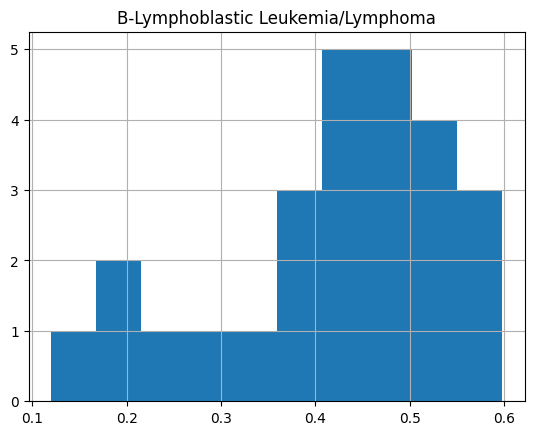

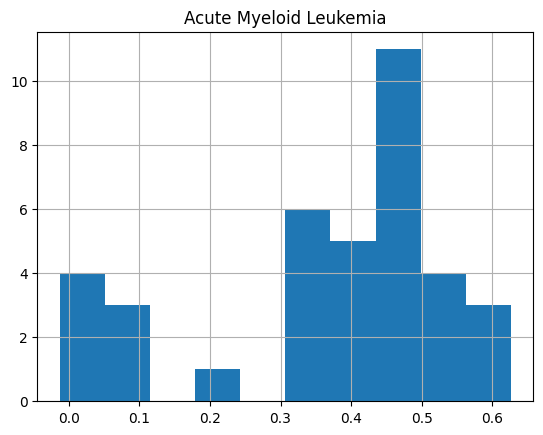

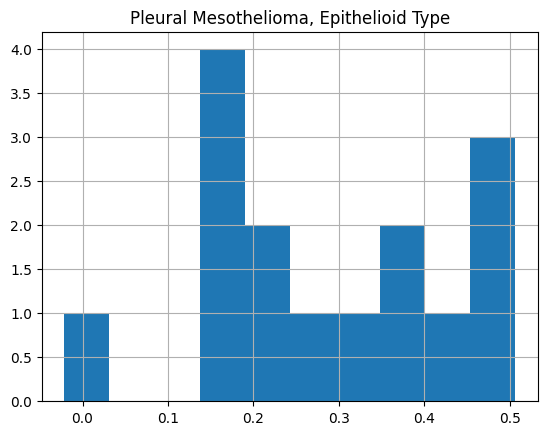

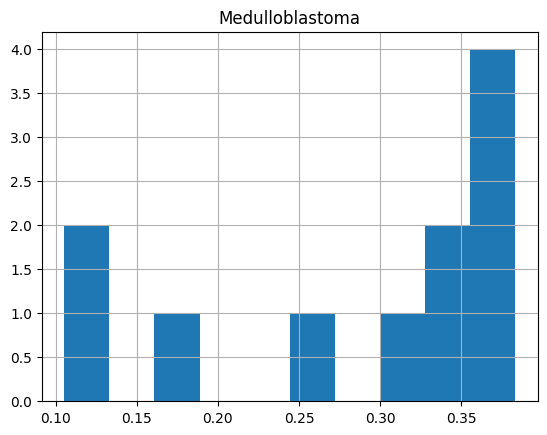

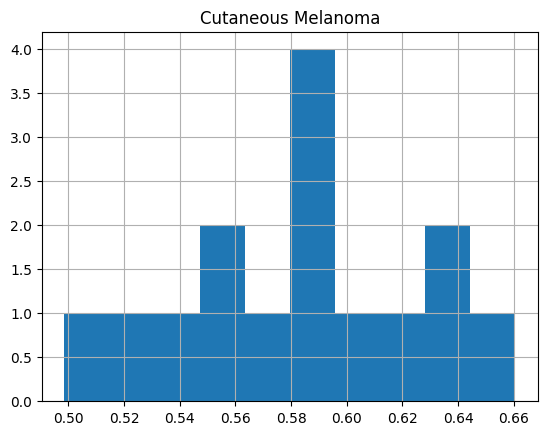

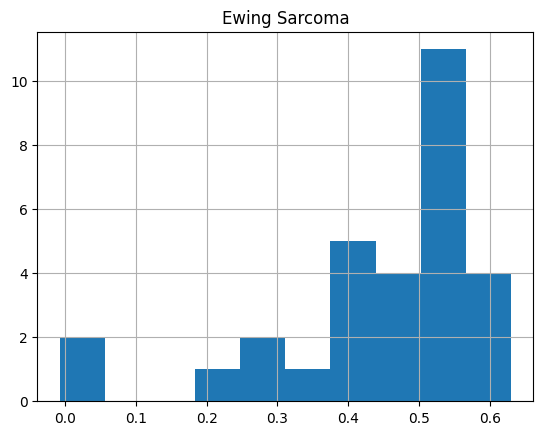

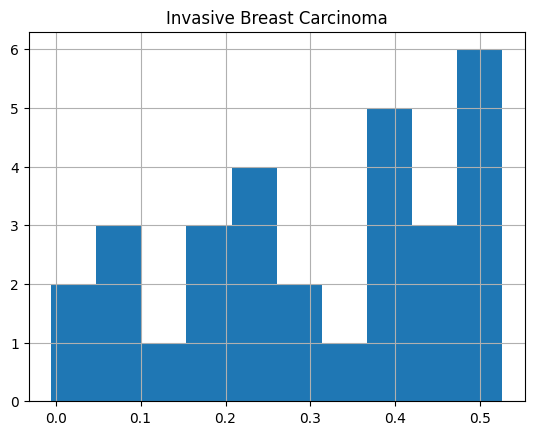

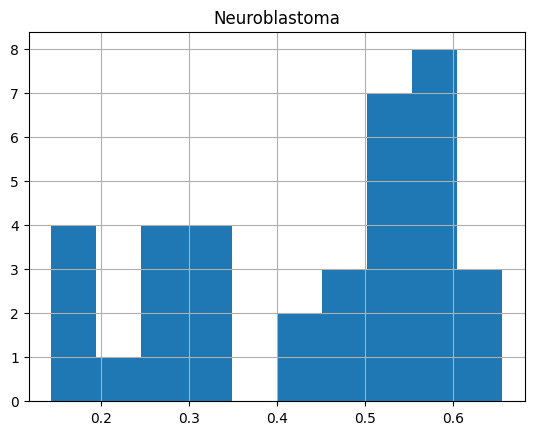

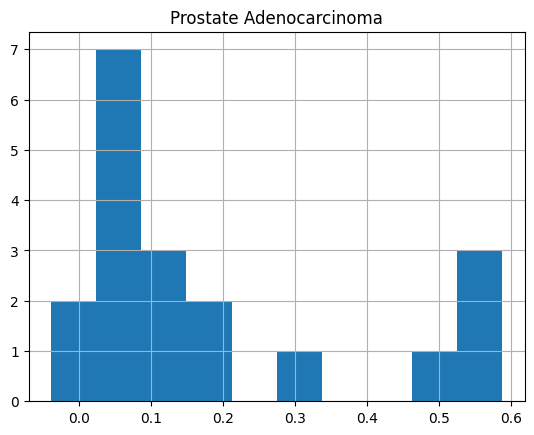

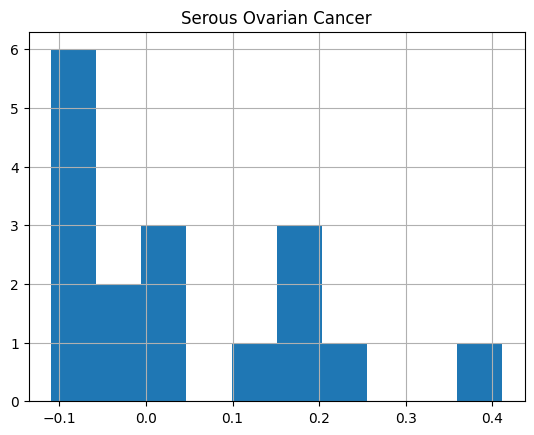

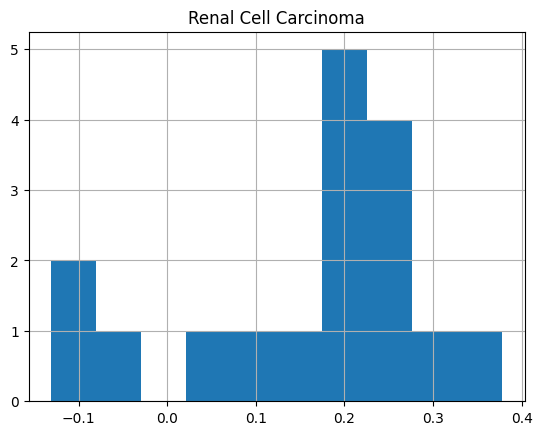

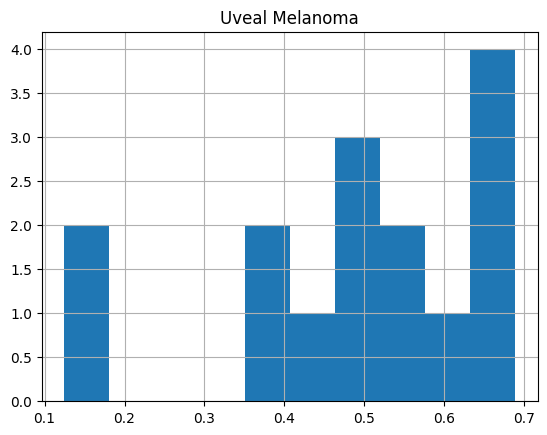

In [496]:
import matplotlib.pyplot as plt

def plot_histograms(projections, unique_df):
    """
    Filters the projections DataFrame based on subtypes in unique_df and plots histograms for each subtype.

    Parameters:
    - projections (DataFrame): The DataFrame containing the projection data with sample IDs as index.
    - unique_df (DataFrame): The DataFrame containing the subtype and sample information.
    """
    subtypes = unique_df['new_subtype'].unique().tolist()

    for subtype in subtypes:
        sample_ids = unique_df[unique_df['new_subtype'] == subtype]['sample']
        
        # Filter projections DataFrame based on these sample IDs
        filtered_projections = projections.loc[sample_ids, subtype]
            
    
        plt.figure()
        filtered_projections.hist()
        plt.title(subtype)
        plt.show()
       

plot_histograms(projections, unique_df)


<Axes: >

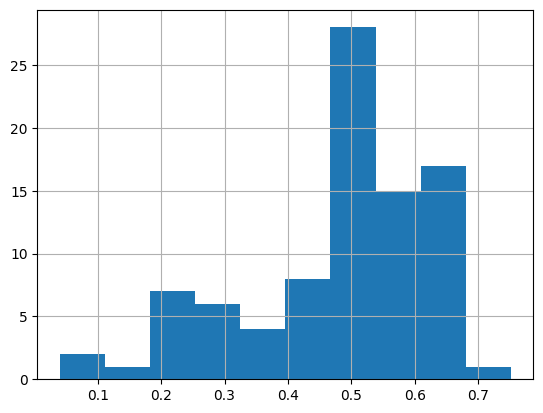

In [473]:
# a histogram of scores of depmap samples with new subtype = Melanoma for the "Cutaneous Melanoma" projection score
melanoma_samples = merged_df[merged_df['new_subtype'] == 'Melanoma']
melanoma_scores = projections.loc[melanoma_samples['sample'], 'Cutaneous Melanoma']
melanoma_scores.hist()


In [474]:
lineageprojections=pd.read_csv('/Users/nabdirah/Project1/lineageprojection.csv')

In [486]:
lineageprojections=lineageprojections.set_index('Unnamed: 0')

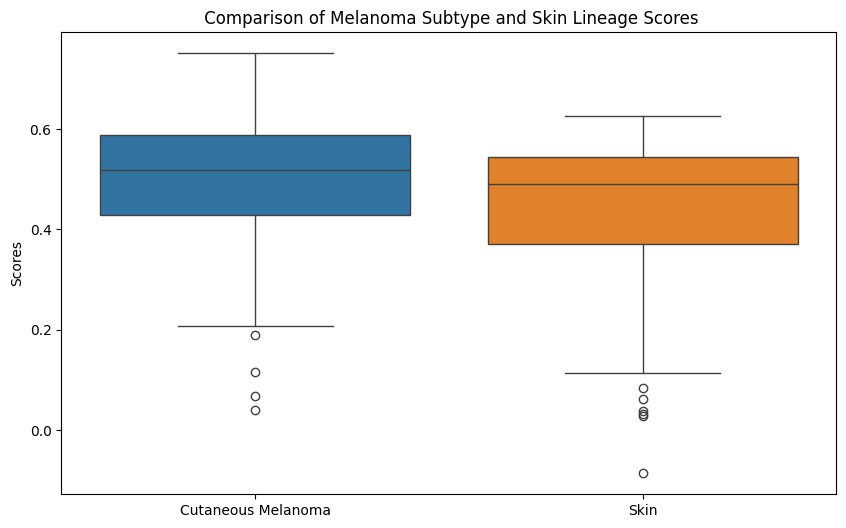

In [503]:
subtype_samples = merged_df[merged_df['new_subtype'] == 'Melanoma']['sample']
lineage_samples =merged_df[merged_df['Lineage'] == 'Skin']['sample']
    
# Collect subtype scores
subtype_scores = projections.loc[subtype_samples, 'Cutaneous Melanoma']
# Collect lineage scores
lineage_scores = lineageprojections.loc[lineage_samples, 'Skin']
data = [subtype_scores, lineage_scores]

labels = ['Melanoma Subtype', 'Skin Lineage']
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
#plt.xticks([0, 1], labels)  # Set the x-axis labels
plt.title(' Comparison of Melanoma Subtype and Skin Lineage Scores')
plt.ylabel('Scores')
plt.show()

In [151]:
unique_df.rename(columns={'sample':'sampleID'}, inplace=True)

/var/folders/p8/ns8k_3ds56130jc48rg_027h0000gp/T/ipykernel_28434/1908449022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df.rename(columns={'sample':'sampleID'}, inplace=True)


In [ ]:
print((', ').join(unique_df[unique_df.new_subtype=='squamous']['sample'].tolist()))

In [501]:
projections.loc['ACH-001456']

CNS/Brain                                                        -0.223202
Osteosarcoma                                                     -0.157012
Medulloblastoma                                                   0.074951
Acute Megakaryoblastic Leukemia                                   0.057361
acute lymphoblastic leukemia                                     -0.006083
Rhabdomyosarcoma                                                  0.032841
B-Lymphoblastic Leukemia/Lymphoma                                 0.129608
Acute Myeloid Leukemia                                            0.047835
Ewing Sarcoma                                                    -0.038493
Neuroblastoma                                                     0.051979
Synovial Sarcoma                                                  0.039238
adeno                                                            -0.126140
Hepatocellular Carcinoma                                          0.057630
Adrenocortical Carcinoma 

In [218]:
projections.loc[unique_df[unique_df.new_subtype=='Bladder Urothelial Carcinoma'].sampleID, 'Bladder Urothelial Carcinoma']

ACH-000011   -0.022831
ACH-000384    0.571906
ACH-000545    0.225511
ACH-000720    0.164433
ACH-000741    0.207325
ACH-000026   -0.034302
ACH-000724    0.395997
ACH-000905    0.252623
ACH-000862    0.506394
ACH-000018    0.126887
ACH-000522   -0.013953
ACH-000753    0.027878
ACH-000834    0.412491
ACH-000142    0.404341
ACH-000547    0.342461
ACH-000896    0.219303
ACH-000242    0.580389
ACH-000802    0.212540
ACH-000396    0.126644
ACH-000566    0.016625
ACH-000473    0.520566
ACH-000593    0.066663
ACH-000486    0.195342
ACH-000127    0.075030
ACH-001414    0.266943
ACH-001410    0.137995
ACH-001413    0.128823
ACH-001407    0.189966
ACH-001183    0.483627
ACH-001416    0.606347
ACH-001415    0.520463
ACH-001409    0.390506
ACH-001412    0.336881
Name: Bladder Urothelial Carcinoma, dtype: float64

In [425]:
projections.to_csv('/Users/nabdirah/Project1/subtype_projections.csv')

In [203]:
projections.loc['ACH-001451']

CNS/Brain                                                        -0.171170
Osteosarcoma                                                     -0.053162
Medulloblastoma                                                  -0.010592
Acute Megakaryoblastic Leukemia                                   0.023762
Ependymoma                                                       -0.005851
acute lymphoblastic leukemia                                     -0.020399
Rhabdomyosarcoma                                                 -0.052268
B-Lymphoblastic Leukemia/Lymphoma                                 0.143873
Acute Myeloid Leukemia                                            0.064014
Ewing Sarcoma                                                     0.043963
Neuroblastoma                                                     0.003217
Choroid Plexus Carcinoma                                          0.064305
Synovial Sarcoma                                                  0.071608
adeno                    

In [102]:
# cclf_ids vs non cclf_ids
def get_his(subtype, unique_df, projections,cclf_ids ):
    df_subtype=projections[subtype].to_frame()
    df_subtype['is_cclf']=df_subtype.index.to_series().isin(cclf_ids)
    subtype_model=unique_df[unique_df.new_subtype == subtype]['sample']
    return sns.boxplot(data=df_subtype.loc[subtype_model],x='is_cclf',y=subtype)

<Axes: xlabel='is_cclf', ylabel='adeno'>

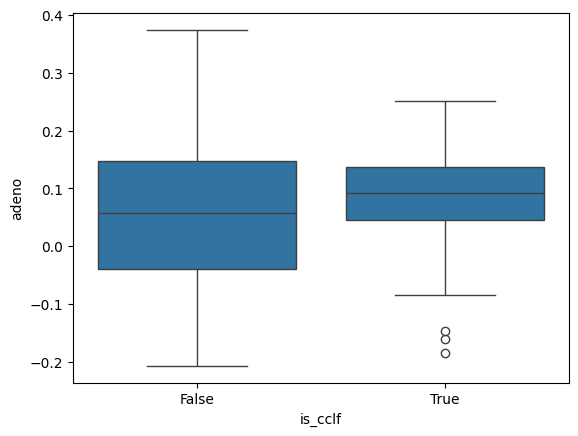

In [103]:
get_his('adeno', unique_df, projections,cclf_ids )

In [ ]:
# Get the counts of each unique value in 'new_subtype'
tcga_meta['new_subtype'].value_counts()

In [ ]:
tcga_meta[tcga_meta.new_subtype == 'Melanoma']['sampleID'].count()
tcga_meta[tcga_meta.derived_lineage=='Skin']['derived_subtype'].value_counts() 

In [ ]:
#
closest_tcgasubtype=pd.merge(merged_df, debmap_table, left_on='subtype' , right_on='closest_tcga_subtype')
closest_tcgasubtype
columns_todrop = ['Unnamed: 0.1', 'Unnamed: 0', 'col1', 'col2', 'subtype_y', 'tissue', 'parent_col1', 'parent_col2']
closest_tcgasubtype = closest_tcgasubtype.drop(columns=columns_todrop)


In [ ]:
closest_tcgasubtype.drop_duplicates()

In [ ]:
# Concatenate DataFrames for each subtype into a single DataFrame
def top_common_subtypes(df):
    """gets the 3 most common subtypes predicted for each subtype"""
    
    subtypes =df.loc[:, ['top1','top2','top3']].values.flatten()  
    subtypes = pd.DataFrame(subtypes, columns=['top_subtypes'])
    top3 = subtypes['top_subtypes'].value_counts().head(3)
    return top3
    
topsubtype=[]
for subtype in merged_df.subtype.unique():
    subtype_df =merged_df[merged_df['subtype'] == subtype]
    top_df = top_common_subtypes(subtype_df)
    topsubtype.append((subtype, top_df))
topsubtype
pair_df = pd.concat(
    [
        # Create a DataFrame for each tuple in 'topsubtype' and assign the 'annotated_subtype' level
        pd.concat({topsubtype[i][0]: pd.DataFrame(data=topsubtype[i][1])}, names=['annotated_subtype']) 
        for i in range(len(topsubtype))
    ]
)

In [73]:
uniqueIds= [
    "ACH-002761", "ACH-002445", "ACH-002414", "ACH-002446", "ACH-002447",
    "ACH-003625", "ACH-002445", "ACH-003474", "ACH-003437", "ACH-002962",
    "ACH-002408", "ACH-002963", "ACH-002935", "ACH-002966", "ACH-003317",
    "ACH-002449", "ACH-002932", "ACH-002838", "ACH-002737", "ACH-002413",
    "ACH-002424", "ACH-002981", "ACH-001433", "ACH-003475", "ACH-002736",
    "ACH-002962", "ACH-002447", "ACH-003463", "ACH-003430", "ACH-003451",
    "ACH-003418", "ACH-001429", "ACH-003430", "ACH-002841", "ACH-003631",
    "ACH-002955", "ACH-002410", "ACH-003423", "ACH-002446", "ACH-003431",
    "ACH-002835", "ACH-002836", "ACH-002983", "ACH-002841", "ACH-002415",
    "ACH-002417", "ACH-002963", "ACH-003479", "ACH-003633", "ACH-002837",
    "ACH-002448", "ACH-002837", "ACH-003432", "ACH-002442", "ACH-002762",
    "ACH-002404", "ACH-003468", "ACH-002412", "ACH-003480", "ACH-002954",
    "ACH-001425", "ACH-002426", "ACH-002420", "ACH-003421", "ACH-002952",
    "ACH-002422", "ACH-001433", "ACH-003481", "ACH-003479", "ACH-002424",
    "ACH-003435", "ACH-002964", "ACH-002981", "ACH-002447", "ACH-002746",
    "ACH-002763", "ACH-002763", "ACH-003436", "ACH-002404", "ACH-002963",
    "ACH-002919", "ACH-003459", "ACH-002967", "ACH-003318", "ACH-002971",
    "ACH-001163", "ACH-003481", "ACH-002957", "ACH-003479", "ACH-001428",
    "ACH-002448", "ACH-002972", "ACH-002959", "ACH-002954", "ACH-003427",
    "ACH-003477", "ACH-003634", "ACH-003317", "ACH-003467", "ACH-002415",
    "ACH-003318", "ACH-002968", "ACH-003454", "ACH-002696", "ACH-003423",
    "ACH-003416", "ACH-003421", "ACH-003430", "ACH-002967", "ACH-002731",
    "ACH-003486", "ACH-003476", "ACH-002411", "ACH-003472", "ACH-001425",
    "ACH-002447", "ACH-003418", "ACH-002942", "ACH-002968", "ACH-002733",
    "ACH-002442", "ACH-003464", "ACH-002838", "ACH-002418", "ACH-002936",
    "ACH-002431", "ACH-002412", "ACH-002777", "ACH-002426", "ACH-002413",
    "ACH-003479", "ACH-002937", "ACH-002736", "ACH-003429", "ACH-002971",
    "ACH-003433", "ACH-002419", "ACH-002959", "ACH-002426", "ACH-002417",
    "ACH-002408", "ACH-002835", "ACH-002410", "ACH-003458", "ACH-002408",
    "ACH-002837", "ACH-002968", "ACH-002954", "ACH-002415", "ACH-002417",
    "ACH-002983", "ACH-002962", "ACH-002431", "ACH-002835", "ACH-002839",
    "ACH-002932", "ACH-003474", "ACH-002405", "ACH-002415", "ACH-003267",
    "ACH-002871", "ACH-003425", "ACH-002411", "ACH-002405", "ACH-003458",
    "ACH-003265", "ACH-003466", "ACH-002730", "ACH-001163", "ACH-001427",
    "ACH-003427", "ACH-001425", "ACH-003485", "ACH-002962", "ACH-002700",
    "ACH-002945", "ACH-003434", "ACH-003430", "ACH-002975", "ACH-003461",
    "ACH-002737", "ACH-003460", "ACH-003476", "ACH-001163", "ACH-002425",
    "ACH-002411", "ACH-002731", "ACH-002411", "ACH-002417", "ACH-002963",
    "ACH-002953", "ACH-003269", "ACH-002420", "ACH-002421", "ACH-002733",
    "ACH-003460", "ACH-002735", "ACH-002952", "ACH-002731", "ACH-002410",
    "ACH-002870", "ACH-003480", "ACH-002954", "ACH-002955", "ACH-002937",
    "ACH-002837", "ACH-003478", "ACH-003456", "ACH-003626", "ACH-002737",
    "ACH-002748", "ACH-002407", "ACH-001427", "ACH-003426", "ACH-002730",
    "ACH-003468", "ACH-002954", "ACH-001425", "ACH-002422", "ACH-003456",
    "ACH-002445", "ACH-003624", "ACH-003451", "ACH-002760", "ACH-002408",
    "ACH-003478", "ACH-002871", "ACH-002403", "ACH-001423", "ACH-002415",
    "ACH-002730", "ACH-003268", "ACH-002871", "ACH-003422", "ACH-003432",
    "ACH-001428", "ACH-002932", "ACH-002869", "ACH-002410", "ACH-002418",
    "ACH-002971", "ACH-002960", "ACH-002965", "ACH-002440", "ACH-002408",
    "ACH-002425", "ACH-002735", "ACH-002968", "ACH-003437", "ACH-002983",
    "ACH-003416", "ACH-002840", "ACH-002952", "ACH-003477", "ACH-003422",
    "ACH-002964", "ACH-002448", "ACH-002981", "ACH-002957", "ACH-001428",
    "ACH-003453", "ACH-002835", "ACH-002958", "ACH-002409", "ACH-002960",
    "ACH-002980", "ACH-002959", "ACH-002737", "ACH-003469", "ACH-002836",
    "ACH-003421", "ACH-002442", "ACH-003453", "ACH-002959", "ACH-001429",
    "ACH-002760", "ACH-003422", "ACH-003429", "ACH-002966", "ACH-002870",
    "ACH-002734", "ACH-002746", "ACH-003426", "ACH-002982", "ACH-002964",
    "ACH-002955", "ACH-002412", "ACH-001163", "ACH-002936", "ACH-002449",
    "ACH-002966", "ACH-002733", "ACH-002736", "ACH-002763", "ACH-002836",
    "ACH-003465", "ACH-002449", "ACH-002736", "ACH-002965", "ACH-002957",
    "ACH-003469", "ACH-003424", "ACH-002965", "ACH-002964", "ACH-003431",
    "ACH-002972", "ACH-001425", "ACH-002919", "ACH-002443", "ACH-003199",
    "ACH-002761", "ACH-001423", "ACH-003626", "ACH-002958", "ACH-002424",
    "ACH-002423", "ACH-003417", "ACH-002945", "ACH-003481", "ACH-003463",
    "ACH-002835", "ACH-002412", "ACH-002945", "ACH-002954", "ACH-002972",
    "ACH-003427", "ACH-002737", "ACH-002431", "ACH-002935", "ACH-002699",
    "ACH-002983", "ACH-002840", "ACH-002841", "ACH-001429", "ACH-002413",
    "ACH-003265", "ACH-003420", "ACH-002871", "ACH-002443", "ACH-002836",
    "ACH-003438", "ACH-003417", "ACH-003318", "ACH-003433", "ACH-003431",
    "ACH-002748", "ACH-003318", "ACH-002966", "ACH-003480", "ACH-003434",
    "ACH-002421", "ACH-003427", "ACH-002839", "ACH-001428", "ACH-002762",
    "ACH-003431", "ACH-003624", "ACH-001428", "ACH-002403", "ACH-003634",
    "ACH-003424", "ACH-002972", "ACH-003478", "ACH-002967", "ACH-002981",
    "ACH-003459", "ACH-002443", "ACH-002699", "ACH-002969", "ACH-002968",
    "ACH-003464", "ACH-002980", "ACH-002964", "ACH-003631", "ACH-003473",
    "ACH-003477", "ACH-002414", "ACH-002959", "ACH-002975", "ACH-003416" ]




In [ ]:
subtype_lineage[subtype_lineage.subtype.isin(['Embryonal Carcinoma', 'Mixed Germ Cell Tumor', 'Choriocarcinoma'])]